In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [209]:
import datetime

In [206]:
import pickle
from os.path import join

# Assumes there is a .obj directory in the notebook folder
def save_obj(obj, name, root=''):
    with open(join(root, '.obj', name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name, root=''):
    with open(join(root, '.obj/', name + '.pkl'), 'rb') as f:
        return pickle.load(f)

We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

The iterable for training data is size 12500.

In [4]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [6]:
def _num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


class Net_C(nn.Module):
    def __init__(self, M, p, N):
        '''
        M is the number of output channels, p is the convolution kernel size, 
        N is the max pooling kernel (ideally, it is a divisor of 33-p)
        '''
        super(Net_C, self).__init__()
        # 3 input image channel, M output channels, pxpx3 square convolution; bias=True is default
        self.conv1 = nn.Conv2d(3, M, p)
        self.pool1 = nn.MaxPool2d(N)
        self.fc1 = nn.Linear(M*((33-p)//N)**2, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = self.fc1(x)
        return x
    
    def num_flat_features(self, x):
        return _num_flat_features(x)
    

class Net_B(nn.Module):
    def __init__(self, M):
        super(Net_B, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, M)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        return _num_flat_features(x)
    

class Net_A(nn.Module):
    def __init__(self):
        super(Net_A, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # 32 * 32 * 3
        x = self.fc1(x) 
        return x
    
    def num_flat_features(self, x):
        return _num_flat_features(x)

In [163]:
def train_net(net, iter_trainloader, iter_testloader, criterion, optimizer, epochs):
    '''
    Trains net and returns epoch-wise test loss
    '''
    epochs_train_error = []
    epochs_test_error = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        # keep track of percentage correct
        total = 0
        correct = 0
        for i, data in enumerate(iter_trainloader):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            # (also do some percent error tallies... before optimization? sure.)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # running calc of error occurs every 4000 mini-batches
            if i % 4000 == 3999:
                epochs_train_error.append([epoch, i, 100 * correct / total])
                total = 0
                correct = 0
        
        # Append the test errors for this epoch
        epochs_test_error.append([epoch, 12500, test_net(net, iter_testloader, criterion)])
    return epochs_train_error, epochs_test_error

In [164]:
def test_net(net, iter_testloader, criterion):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in iter_testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [24]:
# Shared criterion for loss
criterion_all = nn.CrossEntropyLoss()

working with Network A
---------------

In [274]:
a_params = {  
    'lr': 0.0001,
    'momentum': 0.5,
    'epochs': 16
}

In [275]:
netA = Net_A()

In [276]:
# Declare some optimizer for Net A
optimizerA = optim.SGD(netA.parameters(), lr=a_params['lr'], momentum=a_params['momentum'])

In [277]:
%%time
resA_train, resA_test = train_net(netA, trainloader, testloader, criterion_all, optimizerA, a_params['epochs'])

CPU times: user 26min 26s, sys: 1min 24s, total: 27min 50s
Wall time: 14min 22s


In [278]:
# Save network and parameters (name with time-stamp and percent error)
resA_train = np.array(resA_train)
resA_test = np.array(resA_test)

timestrA = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_obj(name='netA_{}_{}'.format(int(resA_test[-1,2]), timestrA), obj=[netA, resA_train, resA_test, a_params])

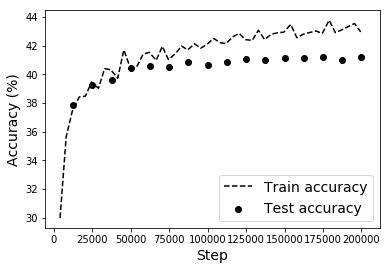

In [279]:
fig, ax = plt.subplots(1)
ax.plot(resA_train[:,0]*12500 + resA_train[:,1], resA_train[:,2], '--', c='k')
ax.scatter(resA_test[:,0]*12500 + resA_test[:,1], resA_test[:,2], c='k')
ax.set_xlabel('Step', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.legend(['Train accuracy', 'Test accuracy'], fontsize=14)
fig.savefig('figs/hw5_p3a_{}.pdf'.format(timestrA))

In [280]:
resA_test[-1,2]

41.22

working with Network B
---------------

In [260]:
b_params = {  
    'lr': 0.001,
    'momentum': 0.7,
    'M': 150,
    'epochs': 16
}

In [261]:
netB = Net_B(b_params['M'])

In [262]:
optimizerB = optim.SGD(netB.parameters(), lr=b_params['lr'], momentum=b_params['momentum'])

In [263]:
%%time
resB_train, resB_test = train_net(netB, trainloader, testloader, criterion_all, optimizerB, b_params['epochs'])

CPU times: user 58min 27s, sys: 2min 9s, total: 1h 36s
Wall time: 29min 5s


In [264]:
# Save network and parameters (name with time-stamp and percent error)
resB_train = np.array(resB_train)
resB_test = np.array(resB_test)

timestrB = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_obj(name='netB_{}_{}'.format(int(resB_test[-1,2]), timestrB), obj=[netB, resB_train, resB_test, b_params])

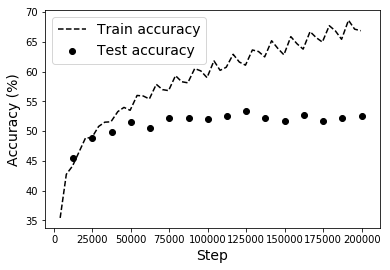

In [265]:
fig, ax = plt.subplots(1)
ax.plot(resB_train[:,0]*12500 + resB_train[:,1], resB_train[:,2], '--', c='k')
ax.scatter(resB_test[:,0]*12500 + resB_test[:,1], resB_test[:,2], c='k')
ax.set_xlabel('Step', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.legend(['Train accuracy', 'Test accuracy'], fontsize=14)
fig.savefig('figs/hw5_p3b_{}.pdf'.format(timestrB))

In [266]:
resB_test[-1,2]

52.52

working with Network C
-----------------------

In [267]:
c_params = {  
    'lr': 0.001,
    'momentum': 0.7,
    'M': 150,
    'p': 6,
    'N': 4,
    'epochs': 16
}

In [268]:
netC = Net_C(c_params['M'], c_params['p'], c_params['N'])

In [269]:
optimizerC = optim.SGD(netC.parameters(), lr=c_params['lr'], momentum=c_params['momentum'])

In [270]:
%%time
resC_train, resC_test = train_net(netC, trainloader, testloader, criterion_all, optimizerC, c_params['epochs'])

CPU times: user 2h 16min 9s, sys: 2min 12s, total: 2h 18min 21s
Wall time: 1h 3min 48s


In [271]:
# Save network and parameters (name with time-stamp and percent error)
resC_train = np.array(resC_train)
resC_test = np.array(resC_test)

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_obj(name='netC_{}_{}'.format(int(resC_test[-1,2]), timestr), obj=[netC, resC_train, resC_test, c_params])

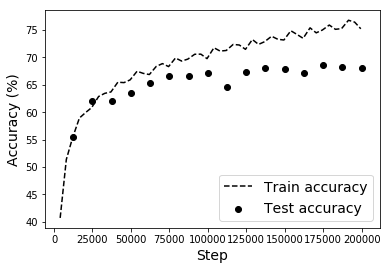

In [272]:
fig, ax = plt.subplots(1)
ax.plot(resC_train[:,0]*12500 + resC_train[:,1], resC_train[:,2], '--', c='k')
ax.scatter(resC_test[:,0]*12500 + resC_test[:,1], resC_test[:,2], c='k')
ax.set_xlabel('Step', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.legend(['Train accuracy', 'Test accuracy'], fontsize=14)
fig.savefig('figs/hw5_p3c_{}.pdf'.format(timestr))

In [273]:
resC_test[-1,2]

68.09

Fun novelty functions 
------------

In [83]:
def categorical_percent_error(net, iter_testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [128]:
categorical_percent_error(netA, testloader)

Accuracy of plane : 64 %
Accuracy of   car : 71 %
Accuracy of  bird : 43 %
Accuracy of   cat : 33 %
Accuracy of  deer : 50 %
Accuracy of   dog : 44 %
Accuracy of  frog : 75 %
Accuracy of horse : 63 %
Accuracy of  ship : 75 %
Accuracy of truck : 55 %


In [252]:
categorical_percent_error(netB, testloader)

Accuracy of plane : 48 %
Accuracy of   car : 57 %
Accuracy of  bird : 30 %
Accuracy of   cat : 33 %
Accuracy of  deer : 31 %
Accuracy of   dog : 32 %
Accuracy of  frog : 59 %
Accuracy of horse : 52 %
Accuracy of  ship : 62 %
Accuracy of truck : 49 %


In [251]:
categorical_percent_error(netC, testloader)

Accuracy of plane : 63 %
Accuracy of   car : 67 %
Accuracy of  bird : 36 %
Accuracy of   cat : 34 %
Accuracy of  deer : 35 %
Accuracy of   dog : 56 %
Accuracy of  frog : 71 %
Accuracy of horse : 62 %
Accuracy of  ship : 66 %
Accuracy of truck : 58 %
